In [1]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import statsmodels
from typing import Tuple, List
import scipy
from scipy.stats import skew, kurtosis
import numpy as np
import os
import powerlaw
from statsmodels.tsa.stattools import acf
from scipy.optimize import curve_fit
from scipy.stats import shapiro
from scipy.stats import anderson
from scipy.stats import poisson
from scipy.stats import chisquare
from statsmodels.tsa.stattools import adfuller
import random
from datetime import datetime, timedelta

In [2]:
def collect_data(path):
    #help to collect agents data given the iteration_info path
    csv_files = [file for file in os.listdir(path)]
    sim = {"lt":[], "mm":[]}
    for file in csv_files:
        file_name, e = os.path.splitext(file)
        
        if file_name.startswith("sep_trader_lt"):
            sim["lt"].append(pd.read_csv(os.path.join(path, file)))
        elif file_name.startswith("sep_trader_mm"):
            sim["mm"].append(pd.read_csv(os.path.join(path, file)))
    return sim


In [3]:
def modify_mm_data(data):
    #input data structure: list(data class) - list(sims) - dict(mm/lt) - list(agents) - df(agent)
    #pulling market maker 1's data and modify it
    mm_data = []
    for i in range(len(data)):
        mm_data.append(pull_data(data[i]["mm"][0]))
    return mm_data

In [4]:
def pull_data(in_data, isReal = False):
    if isReal:
        data = pd.DataFrame()
        data["midprice"] = in_data.iloc[:, 1]
        data["returns"] = data["midprice"].pct_change()
        with pd.option_context("mode.use_inf_as_null", True):
            data = data.dropna()

        return data

    data = pd.DataFrame()

    data["midprice"] = in_data["curr_mp"]
    data["spread"] = in_data["spread"]

    data["returns"] = data["midprice"].pct_change()

    data["bid_volume"] = np.sum(
        [
            in_data["bid_1"],
            in_data["bid_2"],
            in_data["bid_3"],
            in_data["bid_4"],
            in_data["bid_5"],
        ],
        axis=0,
    )
    data["ask_volume"] = np.sum(
        [
            in_data["ask_1"],
            in_data["ask_2"],
            in_data["ask_3"],
            in_data["ask_4"],
            in_data["ask_5"],
        ],
        axis=0,
    )
    # volumes = np.mean(
    #     [
    #         in_data["bid_5"],
    #         in_data["bid_4"],
    #         in_data["bid_3"],
    #         in_data["bid_2"],
    #         in_data["bid_1"],
    #         in_data["ask_1"],
    #         in_data["ask_2"],
    #         in_data["ask_3"],
    #         in_data["ask_4"],
    #         in_data["ask_5"],
    #     ],
    #     axis=1,
    # )
    data["volume_inbalance"] = np.subtract(data["bid_volume"], data["ask_volume"])

    with pd.option_context("mode.use_inf_as_null", True):
        data = data.dropna()
    
    return data


In [5]:
def collect_data_flash_time(path):
    csv_files = [file for file in os.listdir(path)]
    print(csv_files)
    sim = {"flash":[], "mm":[]}
    for file in csv_files:
        file_name, e = os.path.splitext(file)
        if file_name.startswith("sep_trader_mm"):
            sim["mm"].append(pd.read_csv(os.path.join(path, file)))
        elif file_name.startswith("flash_orders"):
            sim["flash"].append(pd.read_csv(os.path.join(path, file)))
    return sim

In [6]:
#collect data
base_path = "/home/shiftpub/sims_final/flash_time"#_up

flash_train_data=[]
flash_test_data=[]
flash_ZI_data = []
flash_non_train_data=[]

flash_train_path = os.path.join(base_path, f"train")
flash_train_data.append(collect_data_flash_time(flash_train_path))
flash_test_path = os.path.join(base_path, f"test")
flash_test_data.append(collect_data_flash_time(flash_test_path))
flash_non_train_path = os.path.join(base_path, f"non_train")
flash_non_train_data.append(collect_data_flash_time(flash_non_train_path))

['sep_trader_mm5.csv', 'sep_trader_mm4.csv', 'sep_trader_mm2.csv', 'flash_orders.csv', 'sep_trader_mm3.csv', 'sep_trader_mm1.csv']
['sep_trader_mm5.csv', 'sep_trader_mm4.csv', 'sep_trader_mm2.csv', 'flash_orders.csv', 'sep_trader_mm3.csv', 'sep_trader_mm1.csv']
['flash_orders.csv', 'sep_trader_mm1.csv', 'iteration_info']


In [ ]:
#collect data
base_path = "/home/shiftpub/sims_final/40_order_len"
base2_path = "/home/shiftpub/sims_final/flash"
base_mid_path = "/home/shiftpub/sims_final/flash_mid"

flash_train_data=[]
flash_test_data=[]
non_train_data = []
test_data = []
flash_mid_data = []

for i in range(10):
    if i != 8:
        path = os.path.join(base_path, f"{i}")
        flash_train_path = os.path.join(path, f"flash_train/iteration_info")
        flash_train_data.append(collect_data(flash_train_path))
        flash_test_path = os.path.join(path, f"flash_test")
        flash_test_data.append(collect_data(flash_test_path))


In [8]:
#session_id,real_time,execution_time,symbol,price,size,trader_id_1,trader_id_2,order_id_1,order_id_2,order_type_1,order_type_2,time_1,time_2,decision,destination
#95ab49d0-d182-49ca-81a4-e19a19eb2838,2023-10-12 23:33:04.315768,2018-12-17 09:35:08.442076,CS1,100.01,31,eef4a6a0-b293-4f83-b18c-4cc647916115,b4b23cfc-03dc-415b-9f35-5a07832a1c40,5a53bcf6-face-496c-98d1-50ddef5fcb5a,59ed7f50-6457-4fc7-b634-e9595ae908fb,2,3,2018-12-17 09:35:08.378819,2018-12-17 09:35:08.440813,2,SHIFT

def modify_rec(data, time):
    datetime_format = "%Y-%m-%d %H:%M:%S.%f"
    # rec = data[(data['order_type_1'] != 5) & (data['order_type_1'] != 6)]
    # rec = rec[(data['order_type_2'] != 5) & (data['order_type_2'] != 6)]
    rec = data
    for i in range(len(data["price"])):
        if rec['order_type_2'][i] == 5 or rec['order_type_2'][i] == 6:
            rec['price'][i] = rec["price"][i-1]
    rec = rec[["execution_time", "price", "size"]]
    #print(rec)
    rec['execution_time'] = pd.to_datetime(rec['execution_time'], format=datetime_format)
    rec.set_index('execution_time', inplace=True)
    result_df = rec.resample(f'{time}S').agg({'price': 'std', 'size': 'sum'}).dropna()
    #result_df["abs_ret"] = abs(result_df["price"].pct_change())

    return(result_df.dropna())

def modify_real_rec(data):
    rec = data[(data['type'] == 1) ]#& (data['type'] == 5)
    rec = rec[["time", "price", "size"]]
    midnight = datetime.strptime('00:00:00', '%H:%M:%S')
    rec['time'] = [midnight + timedelta(seconds=time) for time in rec['time']]
    rec.set_index('time', inplace=True)
    result_df = rec.resample(f'{time}S').agg({'price': 'std', 'size': 'sum'}).dropna()
    #result_df["abs_ret"] = abs(result_df["price"].pct_change())
    return(result_df.dropna())


In [55]:
#collect trading record data
base_path = "/home/shiftpub/sims_final/40_order_len"
base2_path = "/home/shiftpub/shift-rl-sim/simulation"

#2
path = os.path.join(base_path, "2")
train_rec_path = os.path.join(path, f"flash_train/iteration_info")
train_rec=pd.read_csv(os.path.join(train_rec_path, "trade_rec.csv"))
goog_rec=pd.read_csv(os.path.join(base2_path, "GOOG_order.csv"))


In [ ]:
train_l = []
for i in range(10):
    train = modify_rec(train_rec, i+1)
    train_l.append(np.corrcoef(train["size"], train["price"])[0,1])
plt.plot(train_l)
plt.show()
real_l = []
for i in range(10):
    real = modify_real_rec(goog_rec)
    real_l.append(np.corrcoef(real["size"], real["price"])[0,1])
plt.plot(real_l)
plt.show()


In [ ]:
train = modify_real_rec(goog_rec)
list = []
for i in range(100):
    list.append(np.corrcoef(train["size"][i:], train["price"][:len(train["price"])-i])[0,1])
plt.plot(list)
plt.show()

train = modify_rec(train_rec)
list = []
for i in range(100):
    list.append(np.corrcoef(train["size"][i:], train["price"][:len(train["price"])-i])[0,1])
plt.plot(list)
plt.show()

In [9]:
def get_mm_flash_time(flash_data):
    numbers = list(range(0, 440, 5))
    datetime_format = "%Y-%m-%d %H:%M:%S.%f"
    signal_time = [datetime.strptime(flash_data[0]["flash"][0]["time"][i], datetime_format)  for i in numbers]
    mm_time = [datetime.strptime(flash_data[0]["mm"][0]["time"][i], datetime_format)  for i in range(len(flash_data[0]["mm"][0]["time"]))]
    return([min(range(len(mm_time)), key=lambda i: abs(mm_time[i] - signal_time)) for signal_time in signal_time])


In [10]:
flash_train_mm = modify_mm_data(flash_train_data)
# non_train_mm = modify_mm_data(non_train_data)
# test_mm = modify_mm_data(test_data)
flash_test_mm = modify_mm_data(flash_test_data)


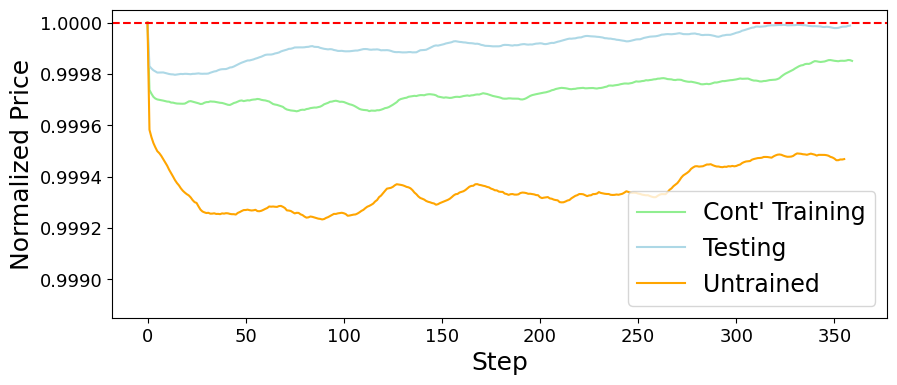

In [15]:
#plot([flash_train_data, flash_test_data, flash_non_train_data], ["Continual Train", "Test", "Non Train"], 0,20 )#73, 85
prev_num = 0
num_slices = 20
types = ["Cont' Training", "Testing", "Untrained"]
all_train_price_mean, all_test_price_mean, all_nontrain_price_mean = [],[],[]
all_train_price, x  = plot_with_time(flash_train_data, num_slices)
all_test_price, y  = plot_with_time(flash_test_data, num_slices)
all_nontrain_price,z  = plot_with_time(flash_non_train_data, num_slices)

#print(len(train_price[0]))
    
for i in range(len([flash_train_data])):
    all_train_price_mean.append([np.mean(x) for x in zip(*all_train_price[i][prev_num:num_slices])])
    all_test_price_mean.append([np.mean(x) for x in zip(*all_test_price[i][prev_num:num_slices])])
    all_nontrain_price_mean.append([np.mean(x) for x in zip(*all_nontrain_price[i][prev_num:num_slices])])

train_p, test_p, nontrain_p = [],[],[]
train_result, test_result, nontrain_result = [],[],[]


train_p = [np.mean(x) for x in zip(*all_train_price_mean)]
train_result = [1] + list(pd.DataFrame(train_p, columns=['Value'])['Value'].rolling(window=20).mean().dropna())
test_p = [np.mean(x) for x in zip(*all_test_price_mean)]
test_result = [1] + list(pd.DataFrame(test_p, columns=['Value'])['Value'].rolling(window=20).mean().dropna())
nontrain_p = [np.mean(x) for x in zip(*all_nontrain_price_mean)]
nontrain_result = [1] + list(pd.DataFrame(nontrain_p, columns=['Value'])['Value'].rolling(window=20).mean().dropna())

#color = sns.color_palette("deep")
plt.figure(figsize=(10, 4))
color = ['orange','lightblue', 'lightgreen']
plt.plot(train_result, label = types[0], color = color[2],alpha = 1)
plt.plot(test_result, label = types[1], color = color[1],alpha = 1)
plt.plot(nontrain_result, label = types[2], color = color[0],alpha = 1)
plt.axhline(y=1, color='red', linestyle='--')
plt.ylim([0.99885, 1.00005])
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.xlabel("Step", fontsize=18)
plt.ylabel("Normalized Price", fontsize=18)
plt.legend(loc='lower right', fontsize=17)
plt.show()




In [11]:
def normalize_slices(data):
    final_data = []
    for list_d in data:
        final_data.append([list_d[i]/list_d[0] for i in range(len(list_d))])
    return final_data

In [12]:
def plot_with_time(flash_data, sample_size):
    all_sliced_prices = []
    all_sliced_sp = []
    flash_mm = modify_mm_data(flash_data)
    mm_signal_time_index = get_mm_flash_time(flash_data)
    for i in range(len(flash_mm)):
        price = flash_mm[i].iloc[:,0].values
        sp = flash_mm[i].iloc[:,1].values
        sliced_prices = [price[mm_signal_time_index[i]:mm_signal_time_index[i+1]] for i in range(len(mm_signal_time_index)-1)]
        sliced_prices = normalize_slices(sliced_prices)
        sliced_sp = [sp[mm_signal_time_index[i]:mm_signal_time_index[i+1]] for i in range(len(mm_signal_time_index)-1)]

        all_sliced_prices.append(sliced_prices)
        all_sliced_sp.append(sliced_sp)
        
    return (all_sliced_prices, all_sliced_sp)
 

In [51]:
def plot_help(flash_data, start_step, dur_len):
    all_sliced_prices = []
    all_sliced_sp = []
    for i in range(len(flash_data)):
        price = flash_data[i].iloc[:,0][start_step:].values
        sp = flash_data[i].iloc[:,1][start_step:].values
        sliced_prices = [price[i:i + dur_len] for i in range(0, len(price), dur_len)]
        sliced_sp = [sp[i:i + dur_len] for i in range(0, len(sp), dur_len)]

        all_sliced_prices.append(sliced_prices)
        all_sliced_sp.append(sliced_sp)
        
    return (all_sliced_prices, all_sliced_sp)


In [52]:
def plot(data, data_types, prev_num, num_slices):#train_data, test_data,
    #all_train_price_mean, all_test_price_mean, all_train_sp_mean, all_test_sp_mean = [],[],[],[]
    num_data = len(data)
    all_price_mean = [[]]*num_data
    all_sp_mean = [[]]*num_data
    all_price = [[]]*num_data
    all_sp = [[]]*num_data
    for i in range(num_data):
        all_price[i], all_sp[i] = plot_with_time(data[i], num_slices)

    #print(len(train_price[0]))
        
    for i in range(len(data[0])):
        for type_i in range(num_data):
            all_price_mean[type_i].append([np.mean(x) for x in zip(*all_price[type_i][i][prev_num:num_slices])])
            all_sp_mean[type_i].append([np.mean(x) for x in zip(*all_sp[type_i][i][prev_num:num_slices])])

    p = [[]]*num_data
    result = [[]]*num_data
    for type_i in range(num_data):
        p[type_i] = [np.mean(x) for x in zip(*all_price_mean[type_i])]
        result[type_i] = list(pd.DataFrame(p[type_i], columns=['Value'])['Value'].rolling(window=20).mean().dropna())
        result[type_i] = [1] + result[type_i]


    plt.plot(result[1])
    plt.show()
    plt.figure(figsize=(10, 5))
    
    for type_i in range(num_data):
        plt.plot(result[type_i], label = data_types[type_i])
    plt.xlabel("Step")
    plt.ylabel("Normalized Price")
    plt.title(f"Mean Price Impact")
    plt.ylim = [99.7, 99.9]
    plt.legend(loc='lower right', fontsize='large')
    plt.show()



In [14]:
def plot_prices(data, data_class):
    for i in range(len(data)):
        plt.plot(data[i]["midprice"])
    plt.xlabel("Step")
    plt.ylabel("Price")
    plt.title(f"{data_class} Mid Price Movements")
    plt.show()

In [ ]:
plot(flash_train_mm, flash_test_mm, 20, 340, 405)

In [13]:
def action_plot(non, before, flash, title):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Create box plots for each dataset
    box1 = ax.boxplot(non, positions=[1], widths=0.6, patch_artist=True)
    box2 = ax.boxplot(before, positions=[2], widths=0.6, patch_artist=True)
    box3 = ax.boxplot(flash, positions=[3], widths=0.6, patch_artist=True)

    # Set colors for box plots
    color = sns.color_palette("deep")#[color[4], color[2], color[9]]
    colors = ['orange','lightblue', 'lightgreen']
    for box, color in zip([box1, box2, box3], colors):
        for patch in box['boxes']:
            patch.set_facecolor(color)

    # Plot a line connecting the medians
    median1 = np.median(non)
    median2 = np.median(before)
    median3 = np.median(flash)
    
    plt.plot([1, 2, 3], [median1, median2,median3], color='black', linestyle='-', linewidth=2, marker='o', markersize=8)

    ax.set_xticks([1, 2, 3])
    #plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 16)
    plt.ylim([-0.08,0.08])
    ax.set_xticklabels(['Untrained', 'Testing', 'Cont\' Training'], fontsize = 18)

    
    plt.show()

In [20]:
def action_plot(before, flash, title):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Create box plots for each dataset
    # box1 = ax.boxplot(non, positions=[1], widths=0.6, patch_artist=True)
    box2 = ax.boxplot(before, positions=[1], widths=0.6, patch_artist=True)
    box3 = ax.boxplot(flash, positions=[2], widths=0.6, patch_artist=True)

    # Set colors for box plots
    color = sns.color_palette("deep")#[color[4], color[2], color[9]]
    colors = ['lightblue', 'lightgreen']
    for box, color in zip([box2, box3], colors):#box1,
        for patch in box['boxes']:
            patch.set_facecolor(color)

    # Plot a line connecting the medians
    # median1 = np.median(non)
    median2 = np.median(before)
    median3 = np.median(flash)

    plt.plot([1, 2], [median2,median3], color='black', linestyle='-', linewidth=2, marker='o', markersize=8)

    # Set labels and title
    ax.set_xticks([1,2])
    #plt.title(title)
    plt.ylim([-0.03,0.045])
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    # Display the plot
    ax.set_xticklabels(['Before', 'After'], fontsize = 24)
    plt.show()

In [ ]:
#collect data
base_path = "/home/shiftpub/sims_final/40_order_len"
#base2_path = "/home/shiftpub/sims_final/flash"

flash_train_data=[]
for i in range(10):
    path = os.path.join(base_path, f"{i}")
    flash_train_path = os.path.join(path, f"flash_train/iteration_info")
    flash_train_data.append(collect_data(flash_train_path))


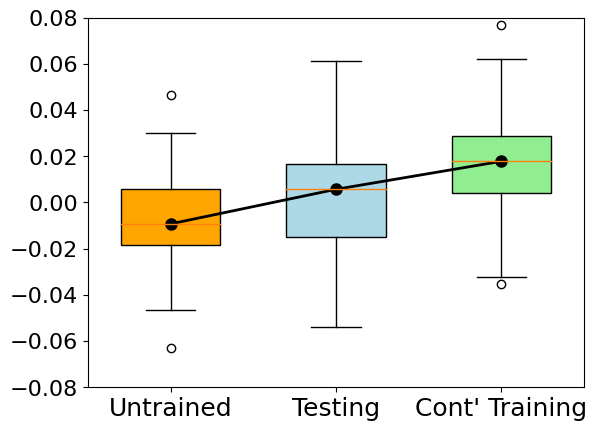

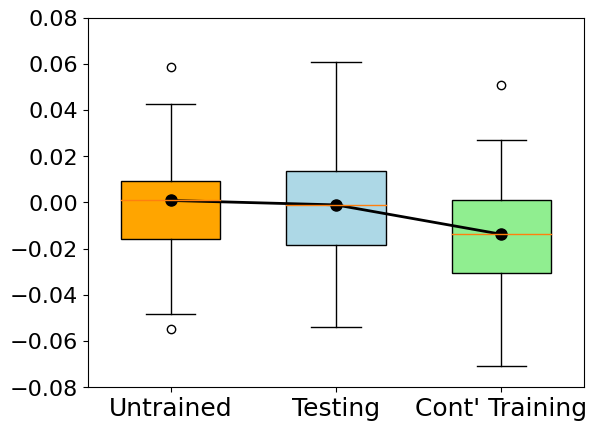

In [14]:
after_data = pd.read_csv("test_action_output_after.csv")
before_data = pd.read_csv("test_action_output_before.csv")
non_data = pd.read_csv("test_action_output_non.csv")

after_sym = list(after_data["action_sym"])
after_asym = list(after_data["action_asym"])


before_sym = list(before_data["action_sym"])
before_asym = list(before_data["action_asym"])

non_sym = list(non_data["action_sym"])
non_asym = list(non_data["action_asym"])

action_plot(non_sym, before_sym, after_sym, "Action Sym")
action_plot(non_asym, before_asym, after_asym, "Action Asym")


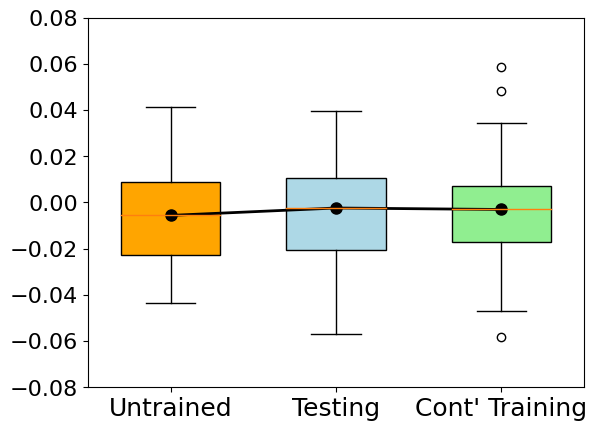

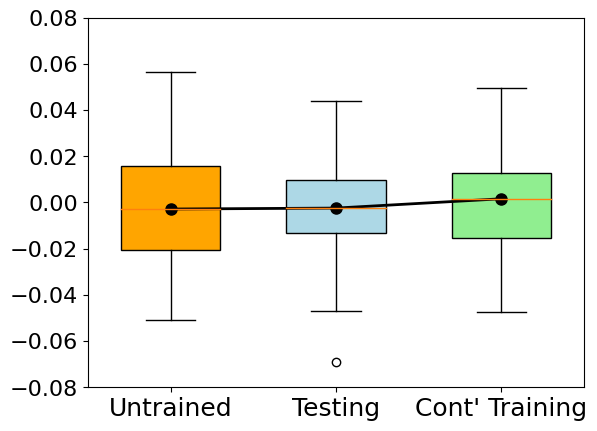

In [15]:
after_data = pd.read_csv("test_action_output_after_balanced.csv")
before_data = pd.read_csv("test_action_output_before_balanced.csv")
non_data = pd.read_csv("test_action_output_non_balanced.csv")

after_sym = list(after_data["action_sym"])
after_asym = list(after_data["action_asym"])


before_sym = list(before_data["action_sym"])
before_asym = list(before_data["action_asym"])

non_sym = list(non_data["action_sym"])
non_asym = list(non_data["action_asym"])

action_plot(non_sym, before_sym, after_sym, "Action Sym")
action_plot(non_asym, before_asym, after_asym, "Action Asym")

In [49]:

up_states = {"his_prices":[], "curr_inv":[], "last_ms":[],
             "ask_b":[], "bid_b":[], "bp":[]}
data = flash_train_data[0]["mm"][0]
count = 0
for i in range(4,len(data)):
    his_prices = []
    for x in range(5):
        his_prices.append(data.iloc[i-x]["curr_mp"])
    ask_b = [data.iloc[i]["ask_1"], data.iloc[i]["ask_2"], data.iloc[i]["ask_3"], data.iloc[i]["ask_4"], data.iloc[i]["ask_5"]]
    bid_b = [data.iloc[i]["bid_1"], data.iloc[i]["bid_2"], data.iloc[i]["bid_3"], data.iloc[i]["bid_4"], data.iloc[i]["bid_5"]]
    
    if (abs(np.max(his_prices) - data.iloc[i]["curr_mp"]) <= 0.03 and
        data.iloc[i]["Ask_depth"] - data.iloc[i]["Bid_depth"] == 0 and
        abs(np.sum(ask_b) - np.sum(bid_b)) <= 20):
        count+=1
        up_states["his_prices"].append(his_prices)
        up_states["curr_inv"].append([data.iloc[i]["current_inventory"]])
        up_states["last_ms"].append([data.iloc[i-1]["current_market_share"]])
        up_states["ask_b"].append(ask_b)
        up_states["bid_b"].append(bid_b)
        up_states["bp"].append([data.iloc[i]["bp"]])

print(count)

/home/shiftpub/miniconda/envs/sep_rlsim/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


49


In [ ]:
from test_action_env import test_action

test_action()

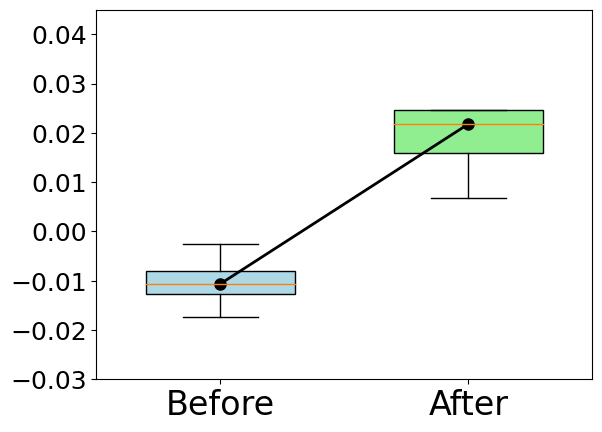

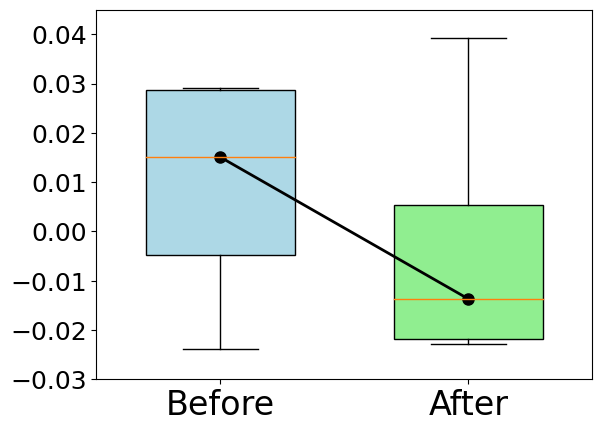

In [21]:
#All LT info, Down
before_sym = -0.01730917,-0.00249194, -0.011231169, -0.010
flash_sym = 0.02468981, 0.0067615425,  0.024624452, 0.019
action_plot(before_sym, flash_sym, "Action Sym")
before_asym = 0.02852547, 0.029105645, 0.0015940113, -0.023807637
flash_asym = 0.03931948,-0.022759065,-0.0058228085,-0.021585908
action_plot(before_asym, flash_asym, "Action Asym")

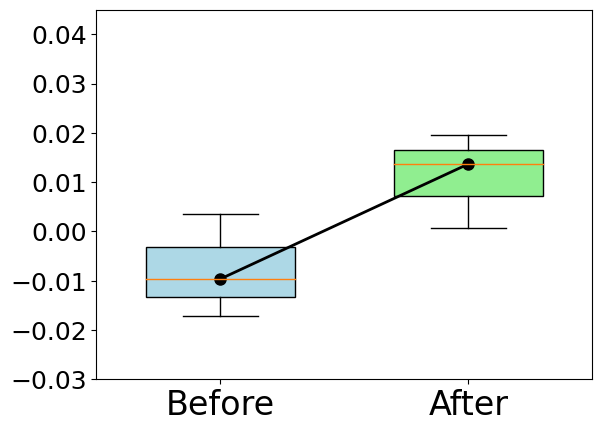

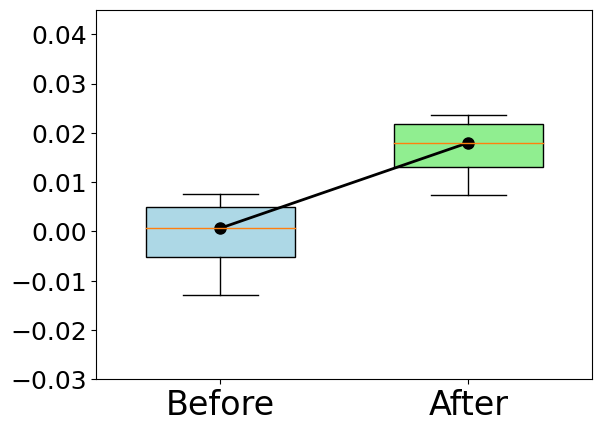

In [22]:
#All LT info, Up
before_sym =  -0.009629461, -0.017066998, 0.0034663144 
flash_sym = 0.01954123, 0.00061264803, 0.013695749
action_plot(before_sym, flash_sym, "Action Sym")
before_asym = 0.003965678, -0.012989861, 0.0076540546, -0.0026186896
flash_asym = 0.0073243873, 0.023625476, 0.014894293, 0.021144744
action_plot(before_asym, flash_asym, "Action Asym")

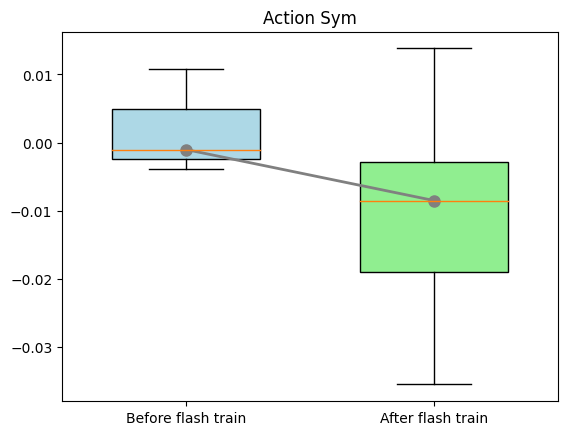

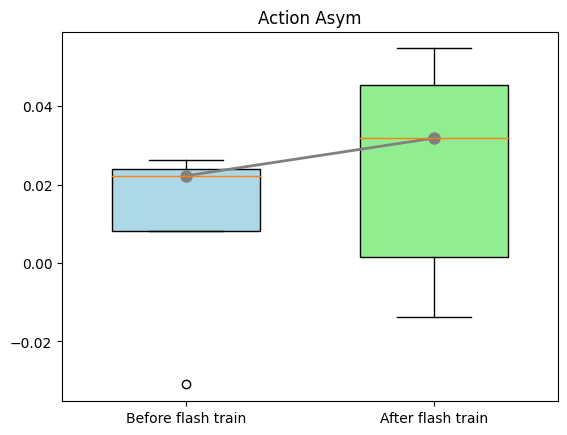

In [8]:
#All LT info, Flat
before_sym = -0.0010202923,  -0.003845092, 0.010796772
flash_sym = -0.0084981825, 0.013798803, -0.035460778, -0.0027805062, -0.019004555
action_plot(before_sym, flash_sym, "Action Sym")
before_asym =  0.021389557, 0.026357742, -0.030962689, 0.023109723
flash_asym = -0.013877615,0.040266037, -0.005804577, 0.047079246, 0.02343864,  0.054717254
action_plot(before_asym, flash_asym, "Action Asym")

In [46]:
#collect trading record data
base_path2 = "/home/shiftpub/sims_final/correct_pnl/0/testing/trade_rec.csv"
#train_rec=pd.read_csv(os.path.join(path, "2nd_train/iteration_info/trade_rec.csv"))
train_rec = pd.read_csv(base_path2)


In [11]:
def calculate_pnl(bid_price, bid_size, ask_price, ask_size):
    pnl = min(bid_size, ask_size)*100 * (ask_price - bid_price)
    if bid_size > ask_size:
        return pnl, [bid_price, bid_size-ask_size, 0,0]
    elif bid_size < ask_size:
        return pnl, [0,0,ask_price, ask_size-bid_size]
    else:
        return pnl, []


In [47]:
datetime_format = "%Y-%m-%d %H:%M:%S.%f"
rec = train_rec
length = len(rec["execution_time"])
#turn all time into datetime format
rec['execution_time'] = pd.to_datetime(train_rec['execution_time'], format=datetime_format)
rec['time_1'] = pd.to_datetime(train_rec['time_1'], format=datetime_format)
rec['time_2'] = pd.to_datetime(train_rec['time_2'], format=datetime_format)
#get total seconds
total_seconds = int((rec["execution_time"][length-1] - rec["execution_time"][0]).total_seconds())

#agent id:
agent_id = "eef4a6a0-b293-4f83-b18c-4cc647916115"
agent_rec = rec.loc[(((rec['trader_id_1']==agent_id) | (rec['trader_id_2']==agent_id))
                     & (rec['price']!=0))]
agent_rec = agent_rec.reset_index()
#agent_rec = agent_rec.loc[0:5000,]
#set up:
spread_pnl = []
#orders_pairs = {'bid_left_size': [], 'bid_price': [], 'ask_left_size': [], 'ask_price': []}
column_names = ['bid_id', 'bid_left_size', 'bid_price', 'ask_id', 'ask_left_size', 'ask_price']
orders_pairs = pd.DataFrame(columns=column_names)

starting_time = int(agent_rec["execution_time"][0].timestamp())
start_index = 0
#start looping
for sec in range(1, total_seconds+1):
    curr_spread_pnl=0
    for i in range(start_index, (start_index+1000)):
        if i == (len(agent_rec)-1):
            break
        #if pass order time pass second time, then next second time
        if((starting_time + sec) - agent_rec["execution_time"][i].timestamp() < 0):
            start_index = i
            spread_pnl.append(curr_spread_pnl)
            break

        #agent is trader 1 or 2
        if agent_rec["trader_id_1"][i] == agent_id: agent_position = 1 
        else: agent_position = 2

        #get order submission sec:
        sub_sec = int(agent_rec[f"time_{agent_position}"][i].timestamp())
        #check if in orders_pairs already:
        if (len(orders_pairs)==0) or (sub_sec not in orders_pairs.index):
            #store data
            if(agent_rec[f"order_type_{agent_position}"][i] in [1,3]):
                new_data = {'bid_id':agent_rec[f"order_id_{agent_position}"][i], 'bid_left_size':agent_rec["size"][i], 
                            'bid_price':agent_rec["price"][i], 'ask_id':0, 'ask_left_size':0, 'ask_price':0}
            else:new_data = {'bid_id':0, 'bid_left_size':0, 'bid_price':0, 'ask_id':agent_rec[f"order_id_{agent_position}"][i], 
                             'ask_left_size':agent_rec["size"][i], 'ask_price':agent_rec["price"][i]}
            orders_pairs.loc[sub_sec] = new_data
        else:#now check if fill the other order or add on top of the saved order
            if(agent_rec[f"order_type_{agent_position}"][i] in [1,3]):#if bid order
                if orders_pairs.loc[sub_sec,"bid_price"] != 0:
                    orders_pairs.loc[sub_sec,"bid_left_size"] += agent_rec["size"][i]
                else:
                    #calculate pnl
                    pnl, left_data = calculate_pnl(agent_rec["price"][i], agent_rec["size"][i], orders_pairs.loc[sub_sec,"ask_price"], orders_pairs.loc[sub_sec,"ask_left_size"])
                    curr_spread_pnl += pnl
                    if len(left_data) == 0:
                        orders_pairs = orders_pairs.drop(sub_sec)
                    else:
                        orders_pairs.loc[sub_sec,"bid_id"] = agent_rec[f"order_id_{agent_position}"][i]
                        orders_pairs.loc[sub_sec,"bid_price"], orders_pairs.loc[sub_sec,"bid_left_size"] = left_data[0], left_data[1]
                        orders_pairs.loc[sub_sec,"ask_price"], orders_pairs.loc[sub_sec,"ask_left_size"] = left_data[2], left_data[3]

            else:# if its an ask order
                if orders_pairs.loc[sub_sec,"ask_price"] != 0:
                    orders_pairs.loc[sub_sec,"ask_left_size"] += agent_rec["size"][i]
                else:
                    #calculate pnl
                    pnl, left_data = calculate_pnl(orders_pairs.loc[sub_sec,"bid_price"], orders_pairs.loc[sub_sec,"bid_left_size"], agent_rec["price"][i], agent_rec["size"][i])
                    curr_spread_pnl += pnl
                    if len(left_data) == 0:
                        orders_pairs = orders_pairs.drop(sub_sec)
                    else:
                        orders_pairs.loc[sub_sec,"ask_id"] = agent_rec[f"order_id_{agent_position}"][i]
                        orders_pairs.loc[sub_sec,"bid_price"], orders_pairs.loc[sub_sec,"bid_left_size"] = left_data[0], left_data[1]
                        orders_pairs.loc[sub_sec,"ask_price"], orders_pairs.loc[sub_sec,"ask_left_size"] = left_data[2], left_data[3]

        
    # if i >=22:
    #     break
        #get this i's order data:
        #agent_rec[]



In [48]:
#set up:
delta_pnl = []
imbalance = []
#orders_pairs = {'bid_left_size': [], 'bid_price': [], 'ask_left_size': [], 'ask_price': []}
position_values =  {'bid_value':0,'bid_size':0,'ask_value':0,'ask_size':0, "imbalanced_prices":[], "imbalanced_sizes":[]}

starting_time = int(agent_rec["execution_time"][0].timestamp())
start_index = 0
#start looping
for sec in range(1, total_seconds+1):#total_seconds
    for i in range(start_index, (start_index+1000)):
        if i == (len(agent_rec)-1):
            break
        #if pass order time pass second time, then next second time
        if((starting_time + sec) - agent_rec["execution_time"][i].timestamp() < 0):
            start_index = i

            # curr_change_pnl = ((position_values["ask_value"]-starting_pos["ask_value"]) - (position_values["bid_value"]-starting_pos["bid_value"])
            #                    - (position_values["imbalanced_value"]))
            imbalanced_values = 0
            if len(position_values["imbalanced_prices"]) != 0:
                for order in range(len(position_values["imbalanced_prices"])):
                    imbalanced_values += position_values["imbalanced_prices"][order] * position_values["imbalanced_sizes"][order]

            curr_change_pnl = ((position_values["ask_value"]) - (position_values["bid_value"]) - imbalanced_values)
            delta_pnl.append(curr_change_pnl)
            break
        
        if agent_rec["trader_id_1"][i] == agent_id: agent_position = 1 
        else: agent_position = 2

        
        #if bid
        if agent_rec[f"order_type_{agent_position}"][i] in [1,3]:
            prev_diff =  position_values["ask_size"] - position_values["bid_size"]
            new_size =  -1 * agent_rec["size"][i]*100
            bid_size = position_values["bid_size"] + agent_rec["size"][i]*100
            ask_size = position_values["ask_size"]
            #for imbalanced value calculation, - if more bid, + if more ask
            diff = ask_size - bid_size
            
            if(ask_size == bid_size):
                position_values["imbalanced_prices"], position_values["imbalanced_sizes"] = [], []
            elif(prev_diff < 0):
                position_values["imbalanced_prices"].append(agent_rec["price"][i]) 
                position_values["imbalanced_sizes"].append(new_size)
            else:
                while new_size < 0 :
                    #if new_size beat all list:
                    if (len(position_values["imbalanced_prices"]) == 0):
                        position_values["imbalanced_prices"].append(agent_rec["price"][i]) 
                        position_values["imbalanced_sizes"].append(new_size)
                        new_size = 0
                    #if new_size is greater than the last in the list:
                    elif abs(new_size) >= abs(position_values["imbalanced_sizes"][len(position_values["imbalanced_sizes"])-1]):
                        new_size = new_size + position_values["imbalanced_sizes"].pop(len(position_values["imbalanced_sizes"])-1)
                        position_values["imbalanced_prices"].pop(len(position_values["imbalanced_prices"])-1)
                    #if new_size is less than the last in the list:
                    else:
                        position_values["imbalanced_sizes"][len(position_values["imbalanced_sizes"])-1] += new_size
                        new_size = 0

            #store values and size
            position_values["bid_value"] += agent_rec["price"][i]*agent_rec["size"][i]*100
            position_values["bid_size"] += agent_rec["size"][i]*100

        
        #if ask  
        else:
            new_size =  agent_rec["size"][i]*100
            ask_size = position_values["ask_size"] + agent_rec["size"][i]*100
            bid_size = position_values["bid_size"]
            #for imbalanced value calculation, - if more bid, + if more ask
            diff = ask_size - bid_size
                       
            if(ask_size == bid_size):
                position_values["imbalanced_prices"], position_values["imbalanced_sizes"] = [], []
            elif(prev_diff > 0):
                position_values["imbalanced_prices"].append(agent_rec["price"][i]) 
                position_values["imbalanced_sizes"].append(new_size)
            else:
                while new_size > 0 :
                    #if current imbalance is greater than the last imbalanced order saved:
                    if (len(position_values["imbalanced_prices"]) == 0):
                        position_values["imbalanced_prices"].append(agent_rec["price"][i]) 
                        position_values["imbalanced_sizes"].append(new_size)
                        new_size = 0
                    elif abs(new_size) >= abs(position_values["imbalanced_sizes"][len(position_values["imbalanced_sizes"])-1]):
                        new_size = new_size + position_values["imbalanced_sizes"].pop(len(position_values["imbalanced_sizes"])-1)
                        position_values["imbalanced_prices"].pop(len(position_values["imbalanced_prices"])-1)
                    else:
                        position_values["imbalanced_sizes"][len(position_values["imbalanced_sizes"])-1] += new_size
                        new_size = 0

            position_values["ask_value"] += agent_rec["price"][i]*agent_rec["size"][i]*100
            position_values["ask_size"] += agent_rec["size"][i]*100
           
        #print(position_values)
  



In [49]:
print("spread_pnl",np.sum(spread_pnl))
print("total_pnl",delta_pnl[len(delta_pnl)-1])
print("inventory_pnl", delta_pnl[len(delta_pnl)-1] - np.sum(spread_pnl))

spread_pnl 1360007.9999999981
total_pnl 1059353.0
inventory_pnl -300654.99999999814


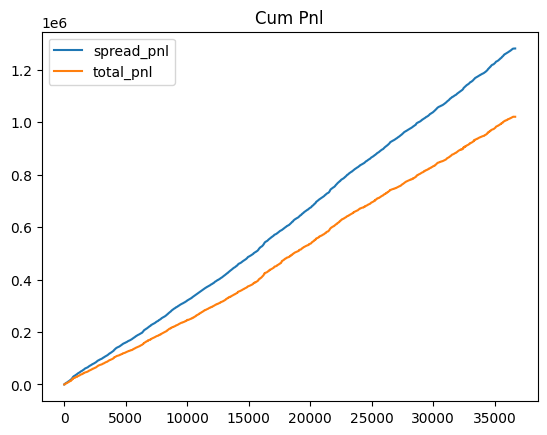

In [105]:
#orders_pairs
plt.plot(np.cumsum(spread_pnl), label = "spread_pnl")
plt.plot((delta_pnl), label = "total_pnl")#
plt.legend(loc = "upper left")
plt.title("Cum Pnl")
plt.show()

In [19]:
#agent id:
agent_id = "152ffca1-e4c4-4e47-a6b5-3f00a2969db6"#"abfa42d3-44d6-41be-9524-d0c794be21d8"
agent_temp = rec.loc[(((rec['trader_id_1']==agent_id) | (rec['trader_id_2']==agent_id))
                     & (rec['price']!=0))]
agent_temp = agent_temp.reset_index()
order_column_names = ['sub_time', 'order_type', 'order_price', 'order_size', 'order_id','execution_time']
agent_bid = pd.DataFrame(columns=order_column_names)
agent_ask = pd.DataFrame(columns=order_column_names)
for i in range(len(agent_temp)):#
    if agent_rec["trader_id_1"][i] == agent_id: agent_position = 1 
    else: agent_position = 2
    new_data = ({'sub_time':agent_temp[f"time_{agent_position}"][i], 'order_type':agent_temp[f"order_type_{agent_position}"][i], 
                            'order_price':agent_temp["price"][i], 'order_size':agent_temp["size"][i], 
                            'order_id':agent_temp[f"order_id_{agent_position}"][i], 'execution_time':agent_temp["execution_time"][i]})
    if agent_temp[f"order_type_{agent_position}"][i] in [1,3]:
        agent_bid.loc[len(agent_bid)] = new_data
        #agent_bid.append(new_data,ignore_index=True)
    else:
        agent_ask.loc[len(agent_ask)] = new_data
        #agent_ask.append(new_data,ignore_index=True)
agent_bid = agent_bid.sort_values(by='sub_time')
agent_ask = agent_ask.sort_values(by='sub_time')

agent_bid.to_csv("agent_bid.csv")
agent_ask.to_csv("agent_ask.csv")
        

In [20]:
# agent_bid = pd.read_csv("agent_bid.csv")
# agent_ask = pd.read_csv("agent_ask.csv")
agent_ask=agent_ask.reset_index()
agent_bid=agent_bid.reset_index()

In [30]:
diff = np.sum(agent_ask["order_size"]) - np.sum(agent_bid["order_size"])
print(np.sum(agent_ask["order_price"]*agent_ask["order_size"]*100) - np.sum(agent_bid["order_price"]*agent_bid["order_size"]*100) 
- (diff*100*np.mean(agent_ask["order_price"])))


1000774.8590907827


In [17]:
temp_size_rec = [0,0]
column_names = ['order_id', "order_type", 'order_size', 'order_price']
leftover_orders = pd.DataFrame(columns=column_names)
cum_pnl = 0
ask_start = 0
for bid_i in range(len(agent_bid)):#len(agent_bid)
    bid_sec = int(agent_bid["sub_time"][bid_i].timestamp())
    temp_size_rec[0]+=agent_bid["order_size"][bid_i]
    # print(bid_i)
    for ask_i in range(ask_start, ask_start+100):
        # print(ask_i)
        if (bid_i >= len(agent_bid)-1) or (ask_i >= len(agent_ask)-1):
            ask_start = ask_i
            break
        ask_sec = int(agent_ask["sub_time"][ask_i].timestamp())
        next_bid_sec = int(agent_bid["sub_time"][bid_i+1].timestamp())
        next_ask_sec = int(agent_ask["sub_time"][ask_i+1].timestamp())
        temp_size_rec[1] += agent_ask["order_size"][ask_i]
        #print(bid_sec,next_bid_sec,ask_sec,next_ask_sec)
        #last loop before next pairs of orders
        if  (bid_sec == ask_sec) & (next_bid_sec != bid_sec) & (next_ask_sec != ask_sec):
            pnl, left_temp = calculate_pnl(agent_bid["order_price"][bid_i], temp_size_rec[0], 
                                           agent_ask["order_price"][ask_i], temp_size_rec[1])
            cum_pnl += pnl
            if len(left_temp)!= 0:
                if left_temp[0] != 0:
                    new_data = {'order_id':agent_bid["order_id"][bid_i], "order_type":agent_bid["order_type"][bid_i],
                                'order_price':left_temp[0], 'order_size':left_temp[1]}
                elif left_temp[2] != 0:
                    new_data = {'order_id':agent_ask["order_id"][ask_i], "order_type":agent_ask["order_type"][ask_i],
                                'order_price':left_temp[2], 'order_size':left_temp[3]}
                leftover_orders.loc[len(leftover_orders)] = new_data
            
            temp_size_rec = [0,0]
            ask_start = ask_i+1
            break
        if (bid_sec == ask_sec) & (bid_sec != next_ask_sec):
            ask_start = ask_i
            temp_size_rec[1]-= agent_ask["order_size"][ask_i]
            break

        #if one new order has no matching order
        #if lacking ask order:
        if bid_sec < ask_sec:
            #save bid order
            new_data = {'order_id':agent_ask["order_id"][ask_i], "order_type":agent_ask["order_type"][ask_i],
                            'order_price':agent_ask["order_price"][ask_i], 'order_size':temp_size_rec[0]}
            leftover_orders.loc[len(leftover_orders)] = new_data
            temp_size_rec[0] = 0
            ask_start = ask_i
            break
        #if lacking bid order:
        elif bid_sec > ask_sec:
            #save ask order
            new_data = {'order_id':agent_bid["order_id"][bid_i], "order_type":agent_bid["order_type"][bid_i],
                            'order_price':agent_bid["order_price"][bid_i], 'order_size':temp_size_rec[1]}
            leftover_orders.loc[len(leftover_orders)] = new_data
            temp_size_rec[1] = 0
            #ask_start = ask_i
            #break
    # print("new_bid")
        
        

In [20]:
print(agent_rec["size"].sum())
print(orders_pairs["bid_left_size"].sum() + orders_pairs["ask_left_size"].sum())
len(orders_pairs)

669453


22740

In [144]:
agent_rec.columns
#09:32:14.104586

/home/shiftpub/miniconda/envs/sep_rlsim/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['index', 'Unnamed: 0', 'session_id', 'real_time', 'execution_time',
       'symbol', 'price', 'size', 'trader_id_1', 'trader_id_2', 'order_id_1',
       'order_id_2', 'order_type_1', 'order_type_2', 'time_1', 'time_2',
       'decision', 'destination'],
      dtype='object')

In [ ]:
#session_id,real_time,execution_time,symbol,price,size,trader_id_1,trader_id_2,order_id_1,order_id_2,order_type_1,order_type_2,time_1,time_2,decision,destination
#95ab49d0-d182-49ca-81a4-e19a19eb2838,2023-10-12 23:33:04.315768,2018-12-17 09:35:08.442076,CS1,100.01,31,eef4a6a0-b293-4f83-b18c-4cc647916115,b4b23cfc-03dc-415b-9f35-5a07832a1c40,5a53bcf6-face-496c-98d1-50ddef5fcb5a,59ed7f50-6457-4fc7-b634-e9595ae908fb,2,3,2018-12-17 09:35:08.378819,2018-12-17 09:35:08.440813,2,SHIFT

def modify_rec(data, time):
    datetime_format = "%Y-%m-%d %H:%M:%S.%f"
    # rec = data[(data['order_type_1'] != 5) & (data['order_type_1'] != 6)]
    # rec = rec[(data['order_type_2'] != 5) & (data['order_type_2'] != 6)]
    rec = data
    for i in range(len(data["price"])):
        if rec['order_type_2'][i] == 5 or rec['order_type_2'][i] == 6:
            rec['price'][i] = rec["price"][i-1]
    rec = rec[["execution_time", "price", "size"]]
    #print(rec)
    rec['execution_time'] = pd.to_datetime(rec['execution_time'], format=datetime_format)
    rec.set_index('execution_time', inplace=True)
    result_df = rec.resample(f'{time}S').agg({'price': 'std', 'size': 'sum'}).dropna()
    #result_df["abs_ret"] = abs(result_df["price"].pct_change())

    return(result_df.dropna())
